tgb - 1/20/20 - Make six-panel figure about the decomposition of the MSE potential. For convenience, we repeat the figures in the main text:  
- Figures 1a and 1b become a and b with the MSE fields and the moist meander  
- Figures 2a and 2b become c and d with the MSE potential and PDF overlaid  
- The last panels e and f are about the potential's decomposition into different contributions

# Initialization

## Imports

In [1]:
# Initial imports
import util.Landau_Potential_Diffusion as Landau
import util.curvature as curve
import util.pdf as PDF

import xarray as xr
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.image as mpimg
from matplotlib.gridspec import GridSpec
import matplotlib as mpl
import matplotlib.transforms as mtransforms
import datetime
from skimage import measure
from scipy import ndimage, stats
import scipy.integrate as sin
from scipy.optimize import curve_fit
from scipy.ndimage.filters import gaussian_filter1d
import random
import pandas as pd

import pickle

In [2]:
# Figure characteristics common to all Figures
fz = 15
lw = 3
siz = 10

plt.rc('text', usetex=False)
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
mpl.rcParams['lines.markersize'] = siz
plt.close('all')

# Physical constants
stday = 24*3600

## Utilities

In [3]:
class Bunch(object):
  
    def __init__(self, adict):
        self.__dict__.update(adict)

In [4]:
def edgTObin(edges):
    return 0.5*(edges[1:]+edges[:-1])

In [5]:
def get_all_values(dic_values):
    values = []
    for i_k, key in enumerate(dic_values.keys()):
        values.extend(dic_values[key])
    return values

In [6]:
def find_index(time_A, time_cond):
    ind = np.where(time_A == time_cond)[0][0]
    return ind

In [7]:
def bin_mid_to_edge(binm):
    bine = 0.5*(binm[:-1]+binm[1:]) # bin_edges[1:-1]
    return np.concatenate(([bine[0]-(bine[2]-bine[1])],bine,[bine[-1]+(bine[2]-bine[1])]))

# COSMO

## Panel a and c: Field, contour and PDF

### Find percentile for contour

In [24]:
path_RCE = '/project/s916/davidle/RCE-MIP/simulations/RCE_300_3km_506x506/output/'

In [8]:
RCE300 = xr.open_mfdataset(path_RCE+'lfff????????.nc')

/users/tbeucler/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: In xarray version 0.13 `auto_combine` will be deprecated.
  coords=coords)
/users/tbeucler/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:783: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset` to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in in future, please use the
new `combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  coords=coords)


In [9]:
RCE300

<xarray.Dataset>
Dimensions:       (bnds: 2, level1: 75, rlat: 506, rlon: 506, soil1: 10, srlat: 506, srlon: 506, time: 2400)
Coordinates:
  * rlon          (rlon) float32 0.0 0.03 0.06 ... 15.089999 15.12 15.15
  * rlat          (rlat) float32 0.0 0.03 0.06 ... 15.089999 15.12 15.15
  * srlon         (srlon) float32 0.015 0.044999998 ... 15.135 15.165
  * srlat         (srlat) float32 0.015 0.044999998 ... 15.135 15.165
    lon           (rlat, rlon) float32 -5.008956e-06 0.029994989 ... 15.149995
    lat           (rlat, rlon) float32 -2.504478e-06 ... 15.149999
    height_2m     float32 2.0
    height_toa    float32 33250.0
  * soil1         (soil1) float32 0.005 0.025 0.07 0.16 ... 1.47 2.86 5.74 11.5
  * time          (time) datetime64[ns] 2011-07-12T12:00:00 ... 2011-10-20T11:00:00
Dimensions without coordinates: bnds, level1
Data variables:
    time_bnds     (time, bnds) datetime64[ns] dask.array<shape=(2400, 2), chunksize=(1, 2)>
    rotated_pole  (time) |S1 b'' b'' b'' b'' b''

Find percentile of antimode

In [10]:
SPINstart = 0 #days
COALstart = 11 #days
COARstart = 25 #days
ENDstart = 85 # days

In [12]:
MSE_PDF_SPIN,SPINedges = np.histogram(RCE300.FMSE[:(24*COALstart),:,:],bins=100,density=True)
MSE_PDF_COAL,COALedges = np.histogram(RCE300.FMSE[(24*COALstart):(24*COARstart),:,:],bins=100,density=True)
MSE_PDF_COAR,COARedges = np.histogram(RCE300.FMSE[(24*ENDstart):,:,:],bins=100,density=True)

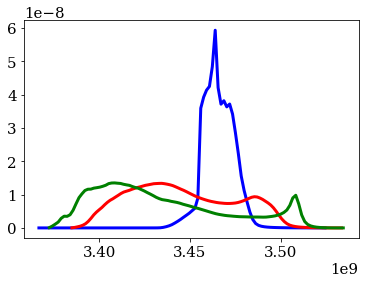

In [13]:
plt.plot(edgTObin(SPINedges),MSE_PDF_SPIN,color='b')
plt.plot(edgTObin(COALedges),MSE_PDF_COAL,color='r')
plt.plot(edgTObin(COARedges),MSE_PDF_COAR,color='g')

In [22]:
np.argmin(MSE_PDF_COAR[20:85])+20

72

In [23]:
SPIN_p88 = np.percentile(RCE300.FMSE[:(24*COALstart),:,:],72)
COAL_p88 = np.percentile(RCE300.FMSE[(24*COALstart):(24*COARstart),:,:],72)
COAR_p88 = np.percentile(RCE300.FMSE[(24*ENDstart):,:,:],72)

In [24]:
MSE_PDF_COAR[72]

3.2273898614867812e-09

In [25]:
SPIN_p88

3470737664.0

In [26]:
SPIN_p88 = np.array([SPIN_p88,MSE_PDF_SPIN[72]])
COAL_p88 = np.array([COAL_p88,MSE_PDF_COAL[72]])
COAR_p88 = np.array([COAR_p88,MSE_PDF_COAR[72]])

### Panel a

In [38]:
MSE_agg = RCE300.FMSE[(24*ENDstart):].mean(dim='time')
toplot = MSE_agg.values

In [55]:
MSE_agg.rlon.shape

(506,)

In [57]:
dx = 3.3
x = dx*np.linspace(0,MSE_agg.rlon.size-1,MSE_agg.rlon.size)
y = dx*np.linspace(0,MSE_agg.rlat.size-1,MSE_agg.rlat.size)

In [33]:
COARbin = edgTObin(COARedges)
COARbnorm = COARbin - COARbin.mean()

In [34]:
COARbnorm

array([-81006590., -79369980., -77733380., -76097020., -74460670.,
       -72824060., -71187460., -69551100., -67914500., -66277890.,
       -64641536., -63005184., -61368576., -59731970., -58095616.,
       -56459010., -54822400., -53186050., -51549696., -49913090.,
       -48276480., -46640130., -45003520., -43366910., -41730560.,
       -40094210., -38457600., -36820990., -35184640., -33548032.,
       -31911424., -30275072., -28638720., -27002112., -25365504.,
       -23729152., -22092544., -20455936., -18819584., -17183232.,
       -15546624., -13910016., -12273664., -10637056.,  -9000448.,
        -7364096.,  -5727744.,  -4091136.,  -2454528.,   -818176.,
          818176.,   2455040.,   4091392.,   5727744.,   7364352.,
         9000960.,  10637312.,  12273664.,  13910528.,  15546880.,
        17183232.,  18819840.,  20456448.,  22092800.,  23729152.,
        25366016.,  27002368.,  28638720.,  30275328.,  31911936.,
        33548288.,  35184640.,  36821504.,  38457856.,  400942

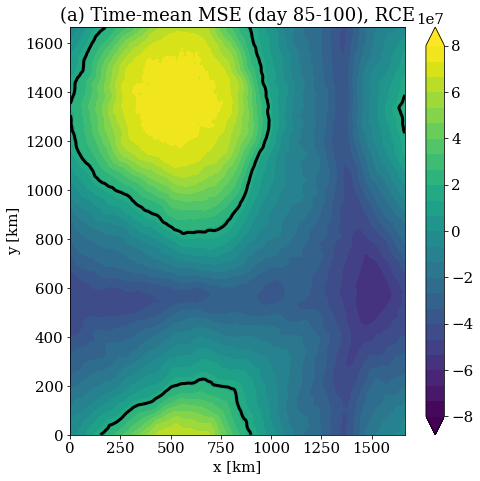

In [58]:
fig,ax = plt.subplots(figsize=(7.5,7.5))

ax.contour(x,y, toplot,[COAR_p88[0]],colors='k')
cont_levels = np.linspace(-8e7,8e7,25)
im = ax.contourf(x, y, toplot-toplot.mean(), cont_levels,
                 vmin = -8e7, vmax = 8e7, extend='both')
ax.set_xlabel('x [km]')
ax.set_ylabel('y [km]')
ax.set_title('(a) Time-mean MSE (day 85-100), RCE')
cbar = plt.colorbar(im)

In [60]:
pathPKL = '/users/tbeucler/2019_WMI/dev/tbeucler/PKL_DATA/'
hf = open(pathPKL+'2020_01_20_MSE_a.pkl','wb')

In [61]:
data = {
    'x':x,'y':y,'toplot':toplot,
    'COAR_p88':COAR_p88
}

In [62]:
pickle.dump(data,hf)
hf.close()

### Panel c

In [65]:
# Load reduced data into dictionary S
pathPKL = '/users/tbeucler/2019_WMI/dev/tbeucler/PKL_DATA/'
path = pathPKL+'2019_11_19_Fig1a.pkl'
hf = open(path,'rb')
S = pickle.load(hf)
Color = Bunch(S)

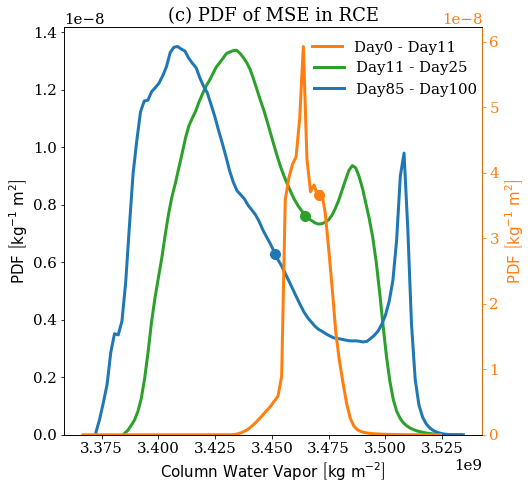

In [76]:
fig,ax = plt.subplots(figsize=(7.5,7.5))

# Figure 1a
ax2 = ax.twinx()

# Shading goes in the back
# ax2.fill_between(edgTObin(F1c.SPINedges),F1c.SPIN_min,F1c.SPIN_max,color=1-(1-F1c.SPINrgb)/2)
# ax.fill_between(edgTObin(F1c.COALedges),F1c.COAL_min,F1c.COAL_max,color=1-(1-F1c.COALrgb)/2)
# ax.fill_between(edgTObin(F1c.COARedges),F1c.COAR_min,F1c.COAR_max,color=1-(1-F1c.COARrgb)/2)

# Right axis = Day 11-100
SPINline = ax2.plot(edgTObin(SPINedges),MSE_PDF_SPIN,color=Color.SPINrgb,label='Day0 - Day11')
# Add dots to indicate mean value of percentile chosen for MMLi
ax2.scatter(x=SPIN_p88[0],
            y=np.interp(x=SPIN_p88[0],xp=edgTObin(SPINedges),fp=MSE_PDF_SPIN),
            color=Color.SPINrgb)

ax2.set_ylabel(r'$\mathrm{PDF\ }\left[\mathrm{kg^{-1}\ m^{2}}\right]$',
               color=Color.SPINrgb)
ax2.spines['right'].set_color(Color.SPINrgb)
ax2.tick_params(axis='y', colors=Color.SPINrgb)
ax2.set_ylim((0,ax2.get_ylim()[1]))
leg2 = ax2.legend(frameon=False,bbox_to_anchor=(0,0,0.97,1))

# Left axis = Day0-Day11
COALline = ax.plot(edgTObin(COALedges),MSE_PDF_COAL,color=Color.COALrgb,label='Day11 - Day25')
COARline = ax.plot(edgTObin(COARedges),MSE_PDF_COAR,color=Color.COARrgb,label='Day85 - Day100')
# Add dots to indicate mean value of percentile chosen for MMLi
ax.scatter(x=COAL_p88[0],
            y=np.interp(x=COAL_p88[0],xp=edgTObin(COALedges),fp=MSE_PDF_COAL),
            color=Color.COALrgb)
ax.scatter(x=COAR_p88[0],
            y=np.interp(x=COAR_p88[0],xp=edgTObin(COARedges),fp=MSE_PDF_COAR),
            color=Color.COARrgb)

leg = ax.legend(frameon=False,bbox_to_anchor=(0,0,1.02,0.95))
ax.set_xlabel(r'$\mathrm{Column\ Water\ Vapor\ }\left[\mathrm{kg\ m^{-2}}\right]$')
ax.set_ylabel(r'$\mathrm{PDF\ }\left[\mathrm{kg^{-1}\ m^{2}}\right]$')
ax.set_ylim((0,ax.get_ylim()[1]))
ax.set_title('(c) PDF of MSE in RCE')

plt.draw()

In [77]:
pathPKL = '/users/tbeucler/2019_WMI/dev/tbeucler/PKL_DATA/'
hf = open(pathPKL+'2020_01_20_MSE_c.pkl','wb')

In [78]:
data = {
    'SPINedges':SPINedges,'COALedges':COALedges,'COARedges':COARedges,
    'MSE_PDF_SPIN':MSE_PDF_SPIN,'MSE_PDF_COAL':MSE_PDF_COAL,'MSE_PDF_COAR':MSE_PDF_COAR,
    'SPINrgb':Color.SPINrgb,'COALrgb':Color.COALrgb,'COARrgb':Color.COARrgb,
    'SPIN_p88':SPIN_p88,'COAL_p88':COAL_p88,'COAR_p88':COAR_p88
}

In [79]:
pickle.dump(data,hf)
hf.close()

## Panel c2: Potential, superposed PDF

In [10]:
pathPKL = '/users/tbeucler/2019_WMI/dev/tbeucler/PKL_DATA/'
hf = open(pathPKL+'2020_01_20_MSE_c.pkl','rb')
S = pickle.load(hf)
Cpdf = Bunch(S)

In [13]:
bin0_final=np.percentile(a=RCE300.FMSE[-24*30:,:,:],q=72,axis=(0,1,2)) # Find reference 0 for potential

In [14]:
dt = 3600; # Timestep in seconds
tcoor = dt*np.arange(0,RCE300.time.shape[0])

In [16]:
hf = open('PKL_DATA/10_15_VCOSMO.pkl','rb')
V_data = pickle.load(hf)
hf.close()

In [17]:
X_pot=V_data["X_pot"]
Vtot=V_data["Vtot"]
Vsef=V_data["Vsef"]
Vsw=V_data["Vsw"]
Vlw=V_data["Vlw"]
Vadv=V_data["Vadv"]
binm=V_data["binm"]

Text(0.5, 1.0, '(c) Potential over RCE simulation')

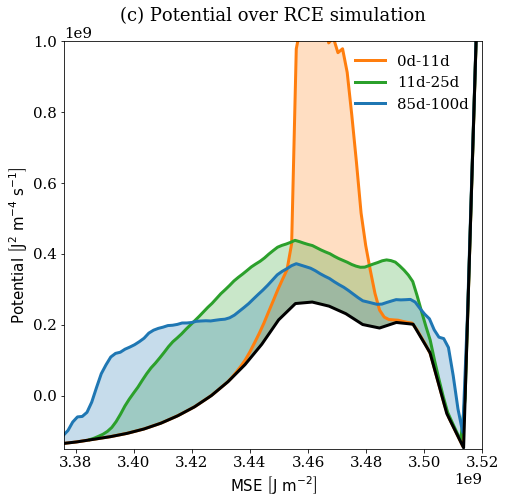

In [43]:
scale_factor = 2e16

fig,ax = plt.subplots(1,1,figsize=(7.5,7.5))

ax.set_xlim((3.376e9,3.52e9))
ax.set_ylim((-1.5e8,1e9))
ax.set_xlabel(r'$\mathrm{MSE}\ \left[\mathrm{J\ m^{-2}}\right]$')
ax.set_ylabel(r'$\mathrm{Potential\ \left[J^{2}\ m^{-4}\ s^{-1}\right]}$')

ax.fill_between((edgTObin(Cpdf.SPINedges)),np.interp(x=edgTObin(Cpdf.SPINedges),xp=binm,fp=Vtot),
                np.interp(x=edgTObin(Cpdf.SPINedges),xp=binm,fp=Vtot)+Cpdf.MSE_PDF_SPIN*scale_factor,
                color=Cpdf.SPINrgb, alpha = 0.25)
ax.fill_between((edgTObin(Cpdf.COALedges)),np.interp(x=edgTObin(Cpdf.COALedges),xp=binm,fp=Vtot),
                np.interp(x=edgTObin(Cpdf.COALedges),xp=binm,fp=Vtot)+Cpdf.MSE_PDF_COAL*scale_factor,
                color=Cpdf.COALrgb, alpha = 0.25)
ax.fill_between((edgTObin(Cpdf.COARedges)),np.interp(x=edgTObin(Cpdf.COARedges),xp=binm,fp=Vtot),
                np.interp(x=edgTObin(Cpdf.COARedges),xp=binm,fp=Vtot)+Cpdf.MSE_PDF_COAR*scale_factor,
                color=Cpdf.COARrgb, alpha = 0.25)

ax.plot((edgTObin(Cpdf.SPINedges)),
        np.interp(x=edgTObin(Cpdf.SPINedges),xp=binm,fp=Vtot)+Cpdf.MSE_PDF_SPIN*scale_factor,
        color=Cpdf.SPINrgb,label='0d-11d')
ax.plot((edgTObin(Cpdf.COALedges)),
        np.interp(x=edgTObin(Cpdf.COALedges),xp=binm,fp=Vtot)+Cpdf.MSE_PDF_COAL*scale_factor,
        color=Cpdf.COALrgb,label='11d-25d')
ax.plot((edgTObin(Cpdf.COARedges)),
        np.interp(x=edgTObin(Cpdf.COARedges),xp=binm,fp=Vtot)+Cpdf.MSE_PDF_COAR*scale_factor,
        color=Cpdf.COARrgb,label='85d-100d')
ax.legend(frameon=False,loc='upper right')

ax.plot(binm,Vtot,color='k')
ax.set_title('(c) Potential over RCE simulation',pad=20)

In [52]:
pathPKL = '/users/tbeucler/2019_WMI/dev/tbeucler/PKL_DATA/'
hf = open(pathPKL+'2020_01_20_MSE_c2.pkl','wb')

In [51]:
data = {
    'binm':binm,'Vtot':Vtot,
    'SPINedges':Cpdf.SPINedges,'VSPIN':np.interp(x=edgTObin(Cpdf.SPINedges),xp=binm,fp=Vtot),
    'SPINpdf':Cpdf.MSE_PDF_SPIN,'SPINrgb':Cpdf.SPINrgb,
    'COALedges':Cpdf.COALedges,'VCOAL':np.interp(x=edgTObin(Cpdf.COALedges),xp=binm,fp=Vtot),
    'COALpdf':Cpdf.MSE_PDF_COAL,'COALrgb':Cpdf.COALrgb,
    'COARedges':Cpdf.COARedges,'VCOAR':np.interp(x=edgTObin(Cpdf.COARedges),xp=binm,fp=Vtot),
    'COARpdf':Cpdf.MSE_PDF_COAR,'COARrgb':Cpdf.COARrgb,
}

In [53]:
pickle.dump(data,hf)
hf.close()

## Panel e: Potential decomposition

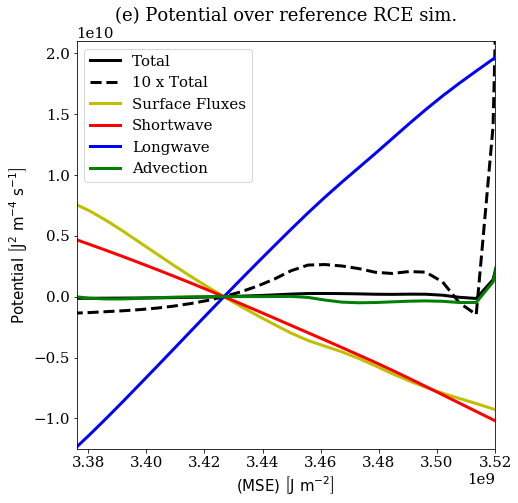

In [56]:
plt.rc('text', usetex=False)
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

fig,ax = plt.subplots(1,1,figsize=(7.5,7.5))
plt.subplots_adjust(hspace=0.33)

#X_pot = (binm-V_data['bin0'])/2.5e6
X_pot = binm
ax.plot(X_pot,Vtot,color='k',label='Total')
ax.plot(X_pot,10*Vtot,color='k',label='10 x Total',linestyle='--')
ax.plot(X_pot,Vsef,color='y',label='Surface Fluxes')
ax.plot(X_pot,Vsw,color='r',label='Shortwave')
ax.plot(X_pot,Vlw,color='b',label='Longwave')
ax.plot(X_pot,Vadv,color='g',label='Advection')
#ax.set_xlim((-19,37))
ax.set_xlim((3.376e9,3.52e9))
#ax.set_ylim((-1.5e8,1e9))
ax.set_ylim((-1.25e10,2.1e10))
ax.set_title('(e) Potential over reference RCE sim.',pad=20)
ax.set_xlabel(r'$\left(\mathrm{MSE}\right)\ \left[\mathrm{J\ m^{-2}}\right]$')
ax.set_ylabel(r'$\mathrm{Potential\ \left[J^{2}\ m^{-4}\ s^{-1}\right]}$')
plt.legend()

# ERA5

## Panel b: Field, contour, PDF

In [8]:
path_ERA = '/project/s916/ERA5_Tom/'

In [9]:
latmin = -23
latmax = 23
lonmin = 360-34
lonmax = 360-18

In [10]:
nbins = 30
xbins = np.linspace(10, 70, 31)

In [11]:
path_JuliaPKL = '/users/tbeucler/2019_WMI/dev/jwindmiller/PKL_DATA/'
dic_hist = np.load(path_JuliaPKL+'CWV_hist_%i_%i_%i_%i_%i.npz'%(nbins, latmin, latmax, lonmin, lonmax))

hist_total = dic_hist['hist_total']
bin_edges = dic_hist['bin_edges']
with open(path_JuliaPKL+'pik_times.dat', 'rb') as f:
    times_A = pickle.load(f)
times_A

[numpy.datetime64('2005-11-23T14:00:00.000000000'),
 numpy.datetime64('2005-12-04T14:00:00.000000000'),
 numpy.datetime64('2005-12-07T14:00:00.000000000')]

In [12]:
date1, date2 = times_A[0],times_A[2]

In [13]:
MSE = xr.open_mfdataset(path_ERA+'????/??MSE.nc',combine='by_coords')

In [14]:
MSE

<xarray.Dataset>
Dimensions:    (latitude: 721, longitude: 1440, time: 166560)
Coordinates:
  * longitude  (longitude) float32 0.0 0.25 0.5 0.75 ... 359.25 359.5 359.75
  * latitude   (latitude) float32 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 2000-01-01 ... 2018-12-31T23:00:00
Data variables:
    p61.162    (time, latitude, longitude) float32 dask.array<shape=(166560, 721, 1440), chunksize=(744, 721, 1440)>
    p62.162    (time, latitude, longitude) float32 dask.array<shape=(166560, 721, 1440), chunksize=(744, 721, 1440)>
Attributes:
    Conventions:  CF-1.6
    history:      2018-10-25 15:55:44 GMT by grib_to_netcdf-2.7.0: /opt/ecmwf...

In [15]:
MSEAtl = MSE['p62.162'].sel({'longitude':slice(lonmin,lonmax),'latitude':slice(latmax,latmin),
                            'time':slice(date1,date2)})
lonAtl = MSE.longitude.sel({'longitude':slice(lonmin,lonmax)})
latAtl = MSE.latitude.sel({'latitude':slice(latmax,latmin)})

In [16]:
times_A[1]

numpy.datetime64('2005-12-04T14:00:00.000000000')

In [17]:
pdf,edges = np.histogram(MSE['p62.162'].sel({'longitude':slice(lonmin,lonmax),'latitude':slice(latmax,latmin),
                            'time':slice(np.datetime64('2005-12-03T14:00:00.000000000'),
                                         np.datetime64('2005-12-05T14:00:00.000000000'))}),
                         bins=100,density=True)

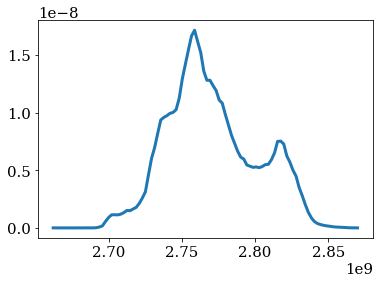

In [18]:
plt.plot(edgTObin(edges),pdf)

In [19]:
np.argmin(pdf[60:77])+60

67

In [20]:
MSEallT = MSE['p62.162'].sel({'longitude':slice(lonmin,lonmax),'latitude':slice(latmax,latmin)})

In [21]:
p67 = {}
pdfmse = {}
edgesmse = {}
for i,times in enumerate(times_A):
    tmp = np.squeeze(MSEallT.sel({'time':slice(times-np.timedelta64(12,'h'), times+np.timedelta64(12,'h'))}).values)
    p67[str(i)] = np.percentile(a=tmp,q=67)
    pdfmse[i],edgesmse[i] = np.histogram(tmp,bins=30,density=True)

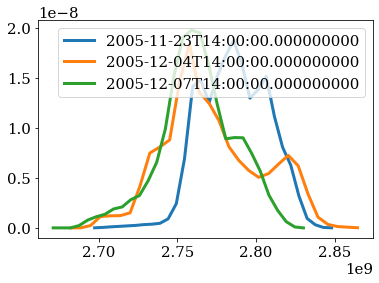

In [22]:
for i,times in enumerate(times_A):
    plt.plot(edgTObin(edgesmse[i]),pdfmse[i],label=times)
plt.legend()

In [23]:
# Average value of the 67th percentile
p67_MSE = np.percentile(a=MSEAtl,q=67)

In [23]:
MSEAtl_mean = MSEallT.mean(dim='time').values

AxesSubplot(0.125,0.125;0.775x0.755)


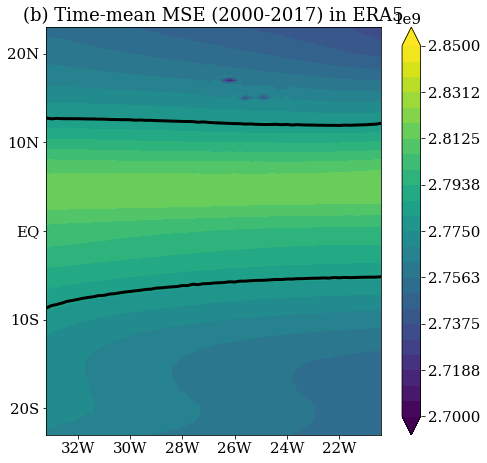

In [27]:
# Multi-year mean of CWV 
fig, axes = plt.subplots(1,1,figsize=(7.5,7.5))

print(axes)

tmp = MSEAtl_mean

axes.contour(lonAtl, latAtl, tmp, [p67_MSE], colors=['k'])#, vmin = 2.7e9, vmax=2.85e9)
cont_levels = np.linspace(2.7e9,2.85e9,25)
im = axes.contourf(lonAtl, latAtl, tmp, cont_levels, vmin = 2.7e9, vmax = 2.85e9, extend='both')

locs = axes.get_xticks()
labels = list(np.arange(len(locs)))
for i_l, loc in enumerate(locs):
    labels[i_l] = '%iW'%int(360-loc)
axes.set_xticklabels(labels) 

locs = axes.get_yticks()
labels = list(np.arange(len(locs)))
for i_l, loc in enumerate(locs):
    if loc >0:
        labels[i_l] = '%iN'%int(loc)
    elif loc == 0:
        labels[i_l] = 'EQ'
    else:
        labels[i_l] = '%iS'%int(loc*-1)
axes.set_yticklabels(labels)
axes.set_title('(b) Time-mean MSE (2000-2017) in ERA5')

cbar = plt.colorbar(im)

In [24]:
pathPKL = '/users/tbeucler/2019_WMI/dev/tbeucler/PKL_DATA/'
hf = open(pathPKL+'2020_01_20_MSE_b.pkl','wb')

In [25]:
data = {
    'lonAtl':lonAtl,'latAtl':latAtl,'p67_MSE':p67_MSE,
    'toplot':MSEAtl_mean
}

In [26]:
pickle.dump(data,hf)
hf.close()

## Panel d: Potential, superposed PDF

In [24]:
dt = 3600
tcoor = dt*np.arange(0,MSEAtl.time.shape[0])

In [25]:
MSE_ext = MSEallT.sel({'time':slice(date1-np.timedelta64(24,'h'), date2+np.timedelta64(24,'h'))}).values

In [26]:
dMSE_dt = (MSE_ext[2:,:,:]-MSE_ext[:-2,:,:])/(2*dt)

In [27]:
pathPKL = '/users/tbeucler/2019_WMI/dev/tbeucler/PKL_DATA/'
hf = open(pathPKL+'2020_01_20_MSE_b.pkl','rb')
S = pickle.load(hf)
B = Bunch(S)

In [28]:
B.p67_MSE

2782086656.0

In [29]:
F,binm,V = Landau.Landau_energy(MSE_ext[1:-1,:,:],dMSE_dt,B.p67_MSE,N_bins=100)

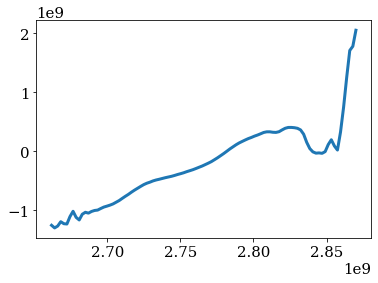

In [30]:
plt.plot(binm,V)

Now restrict potential to the right time-period

In [31]:
dateend = times_A[1]

In [32]:
MSE_ext = MSEallT.sel({'time':slice(date1-np.timedelta64(1,'h'), dateend+np.timedelta64(1,'h'))}).values

In [33]:
dMSE_dt = (MSE_ext[2:,:,:]-MSE_ext[:-2,:,:])/(2*dt)

In [34]:
F,binm,V = Landau.Landau_energy(MSE_ext[1:-1,:,:],dMSE_dt,B.p67_MSE,N_bins=100)

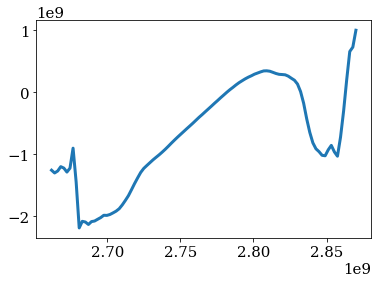

In [35]:
plt.plot(binm,V)

In [36]:
col1 = np.array([255,126,14])/255
col2 = np.array([43,160,43])/255
col3 = np.array([31,119,179])/255

col_A = ['C0', 'C1', 'C2']

In [37]:
times_labels = pd.to_datetime(times_A).strftime("%d-%b")

Text(0.5, 1.0, '(d) Potential over RCE simulation')

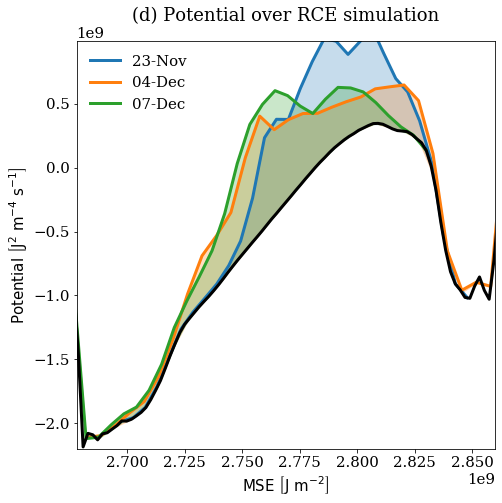

In [100]:
scale_factor = 5e16

fig,ax = plt.subplots(1,1,figsize=(7.5,7.5))

ax.set_ylim((-2.2e9,0.99e9))
ax.set_xlim((2.678e9,2.86e9))
ax.set_xlabel(r'$\mathrm{MSE}\ \left[\mathrm{J\ m^{-2}}\right]$')
ax.set_ylabel(r'$\mathrm{Potential\ \left[J^{2}\ m^{-4}\ s^{-1}\right]}$')

for i in range(3):
    ax.fill_between((edgTObin(edgesmse[i])),np.interp(x=edgTObin(edgesmse[i]),xp=binm,fp=V),
                    np.interp(x=edgTObin(edgesmse[i]),xp=binm,fp=V)+pdfmse[i]*scale_factor,
                    color=col_A[i], alpha = 0.25)

for i in range(3):
    ax.plot((edgTObin(edgesmse[i])),
            np.interp(x=edgTObin(edgesmse[i]),xp=binm,fp=V)+pdfmse[i]*scale_factor,
            color=col_A[i],label=times_labels[i])
    
ax.legend(frameon=False,loc='upper left')

ax.plot(binm,V,color='k')
ax.set_title('(d) Potential over RCE simulation',pad=20)

In [101]:
pathPKL = '/users/tbeucler/2019_WMI/dev/tbeucler/PKL_DATA/'
hf = open(pathPKL+'2020_01_20_MSE_d.pkl','wb')

In [102]:
data = {
    'edgesmse':edgesmse,'binm':binm,'V':V,
    'pdfmse':pdfmse,'col_A':col_A,'times_labels':times_labels
}

In [103]:
pickle.dump(data,hf)
hf.close()

## Panel f: Potential decomposition

In [38]:
PRECIP = xr.open_mfdataset(path_ERA+'????/??PRECIP.nc',combine='by_coords')

In [39]:
SEF0 = xr.open_mfdataset(path_ERA+'????/??SEF.nc',combine='by_coords')

In [40]:
RAD = xr.open_mfdataset(path_ERA+'????/??RAD.nc',combine='by_coords')

In [41]:
LWCOOLAtl = -RAD['ttr'].sel({'longitude':slice(lonmin,lonmax),'latitude':slice(latmax,latmin),'time':slice(date1,dateend)})/3600+\
RAD['str'].sel({'longitude':slice(lonmin,lonmax),'latitude':slice(latmax,latmin),'time':slice(date1,dateend)})/3600

In [42]:
SWAtl = RAD['tsr'].sel({'longitude':slice(lonmin,lonmax),'latitude':slice(latmax,latmin),'time':slice(date1,dateend)})/3600-\
RAD['ssr'].sel({'longitude':slice(lonmin,lonmax),'latitude':slice(latmax,latmin),'time':slice(date1,dateend)})/3600

In [43]:
SEFAtl = -SEF0['mslhf'].sel({'longitude':slice(lonmin,lonmax),'latitude':slice(latmax,latmin),'time':slice(date1,dateend)})-\
SEF0['msshf'].sel({'longitude':slice(lonmin,lonmax),'latitude':slice(latmax,latmin),'time':slice(date1,dateend)})

In [44]:
SEFAtl.shape

(265, 185, 65)

In [ ]:
dMSE_dt.shape

In [ ]:
MSE_ext.shape

### Use total field to calculate potential 

In [82]:
SEFV = SEFAtl.values
tmp,tmp,Vsef = Landau.Landau_energy(MSE_ext[1:-1,:,:],SEFV,B.p67_MSE,N_bins=bin_mid_to_edge(binm))

In [83]:
SWV = SWAtl.values
tmp,tmp,Vsw = Landau.Landau_energy(MSE_ext[1:-1,:,:],SWV,B.p67_MSE,N_bins=bin_mid_to_edge(binm))

In [84]:
LWV = -LWCOOLAtl.values
tmp,tmp,Vlw = Landau.Landau_energy(MSE_ext[1:-1,:,:],LWV,B.p67_MSE,N_bins=bin_mid_to_edge(binm))

In [85]:
tmp,tmp,Vtot = Landau.Landau_energy(MSE_ext[1:-1,:,:],dMSE_dt,B.p67_MSE,N_bins=bin_mid_to_edge(binm))

In [86]:
Vadv = Vtot-Vsef-Vlw-Vsw

### Use anomalies from the mean to calculate potential

In [47]:
SEFAtl

<xarray.DataArray (time: 265, latitude: 185, longitude: 65)>
dask.array<shape=(265, 185, 65), dtype=float32, chunksize=(178, 185, 65)>
Coordinates:
  * longitude  (longitude) float32 326.0 326.25 326.5 ... 341.5 341.75 342.0
  * latitude   (latitude) float32 23.0 22.75 22.5 22.25 ... -22.5 -22.75 -23.0
  * time       (time) datetime64[ns] 2005-11-23T14:00:00 ... 2005-12-04T14:00:00

In [58]:
SEFV = SEFAtl.values - np.moveaxis(np.tile(SEFAtl.mean(dim={'longitude','latitude'}).values,(185,65,1)),2,0)

In [59]:
tmp,tmp,Vsef = Landau.Landau_energy(MSE_ext[1:-1,:,:],SEFV,B.p67_MSE,N_bins=bin_mid_to_edge(binm))

In [60]:
SWV = SWAtl.values - np.moveaxis(np.tile(SWAtl.mean(dim={'longitude','latitude'}).values,(185,65,1)),2,0)
tmp,tmp,Vsw = Landau.Landau_energy(MSE_ext[1:-1,:,:],SWV,B.p67_MSE,N_bins=bin_mid_to_edge(binm))

In [62]:
LWV = -LWCOOLAtl.values - np.moveaxis(np.tile(-LWCOOLAtl.mean(dim={'longitude','latitude'}).values,(185,65,1)),2,0)
tmp,tmp,Vlw = Landau.Landau_energy(MSE_ext[1:-1,:,:],LWV,B.p67_MSE,N_bins=bin_mid_to_edge(binm))

In [64]:
for_pot = dMSE_dt - np.moveaxis(np.tile(dMSE_dt.mean(axis=(1,2)),(185,65,1)),2,0)
tmp,tmp,Vtot = Landau.Landau_energy(MSE_ext[1:-1,:,:],for_pot,B.p67_MSE,N_bins=bin_mid_to_edge(binm))

In [66]:
Vadv = Vtot-Vsef-Vlw-Vsw

In [74]:
tmp,tmp,Vtot0 = Landau.Landau_energy(MSE_ext[1:-1,:,:],dMSE_dt,B.p67_MSE,N_bins=bin_mid_to_edge(binm))

### Panel f

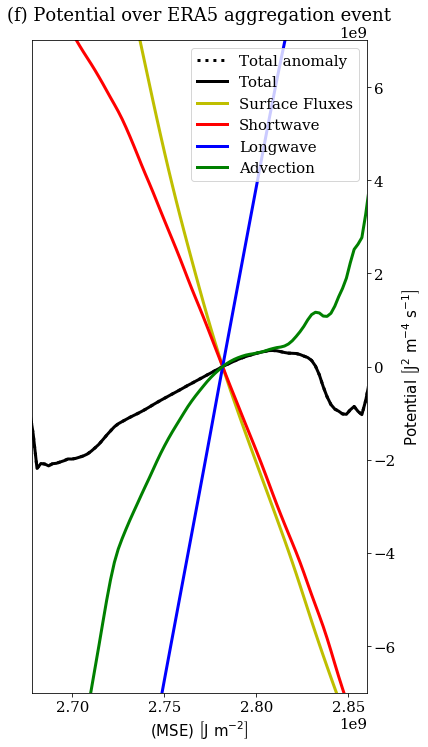

In [87]:
fig,ax = plt.subplots(1,1,figsize=(6,12))

#X_pot = (binm-bin0)/2.5e6
X_pot = binm
ax.plot(X_pot,Vtot,color='k',linestyle=':',label='Total anomaly')
ax.plot(X_pot,Vtot0,color='k',label='Total')
#ax.plot(X_pot,10*Vtot,color='k',label='10 x Total',linestyle='--')
ax.plot(X_pot,Vsef,color='y',label='Surface Fluxes')
ax.plot(X_pot,Vsw,color='r',label='Shortwave')
ax.plot(X_pot,Vlw,color='b',label='Longwave')
ax.plot(X_pot,Vadv,color='g',label='Advection')
ax.set_title('(f) Potential over ERA5 aggregation event',pad=20)
ax.set_xlabel(r'$\left(\mathrm{MSE}\right)\ \left[\mathrm{J\ m^{-2}}\right]$')
ax.set_ylabel(r'$\mathrm{Potential\ \left[J^{2}\ m^{-4}\ s^{-1}\right]}$')
ax.yaxis.tick_right()
ax.yaxis.set_label_position("right")
ax.set_xlim((2.678e9,2.86e9))
ax.set_ylim((-7e9,7e9))
plt.legend()

In [88]:
pathPKL = '/users/tbeucler/2019_WMI/dev/tbeucler/PKL_DATA/'
hf = open(pathPKL+'2020_02_05_MSE_total.pkl','wb')

In [89]:
data = {
    'binm':binm,'Vtot':Vtot,'Vsef':Vsef,'Vsw':Vsw,'Vlw':Vlw,'Vadv':Vadv
}

In [90]:
pickle.dump(data,hf)
hf.close()